In [1]:
pip install pyserial

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import serial
import traceback

# change this to your actual serial port and baud rate
port = 'COM5'  
baud_rate = 4000000  
title=f"small1_8_26"
file=title+".csv"

try:
    ser = serial.Serial(port, baud_rate, timeout=1)
    print(f"Opened serial port: {port} at {baud_rate} baud")

    with open("small_8_26.csv", 'w') as f:
        print("logging started. Ctrl+C to stop.")
        lines=[]
        data=[]
        while True:
            # if ser.inWaiting() > 0:
            #     # print(ser.inWaiting())
            #     data = ser.read(ser.inWaiting())
            #     # print(data + b'\n')
            line = ser.readline().decode('utf-8').strip()
            if line:
                print(line)       # print to console for live view
            if b"^" in data:
                print("found end of file")
                break
            # lines+=data
        # print(lines)
        # for i in lines:    
            f.write(line+'/n')  # save to file
            # else:
            #     break
except KeyboardInterrupt:
    print("\nLogging stopped by user.")
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()
finally:
    print("finally")
    if 'ser' in locals() and ser.is_open:
        ser.close()
        print("Serial port closed.")


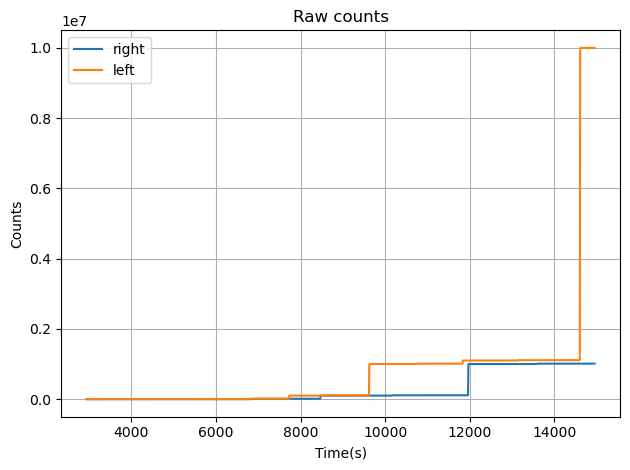

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

#pull data from file
data=pd.read_csv("robot_log_19Aug2025.txt", delimiter=",", header=None)
time = data.iloc[:, 0].to_numpy()
right_count= data.iloc[:, 1].to_numpy()
left_count= data.iloc[:, 2].to_numpy()
right_theta_deg = data.iloc[:, 3].to_numpy()
left_theta_deg = data.iloc[:, 4].to_numpy()
pwra= data.iloc[:,5].to_numpy()
pwrb=data.iloc[:,6].to_numpy()

#plot the raw counts from 0 to infinity
plt.figure()
plt.plot(time, right_count, label='right')
plt.plot(time, left_count, label='left')
plt.xlabel('Time(s)')
plt.ylabel('Counts')
plt.title('Raw counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

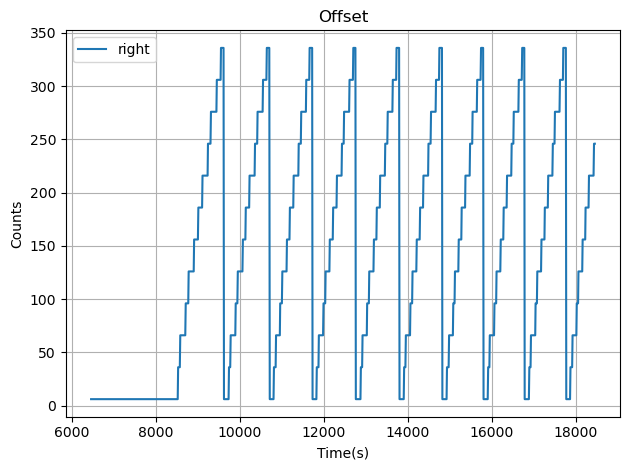

In [16]:
#adding unwrapped ticks and offset
TPR=12
shift=6 #(adds 6 counts from 0 start)

tics=right_count #raw count 0 to infinity
offset=tics+shift #starting offset in ticks

#should be offset shift to infinity
plt.figure()
plt.plot(time, offset, label='right')
plt.xlabel('Time(s)')
plt.ylabel('Counts')
plt.title('Offset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

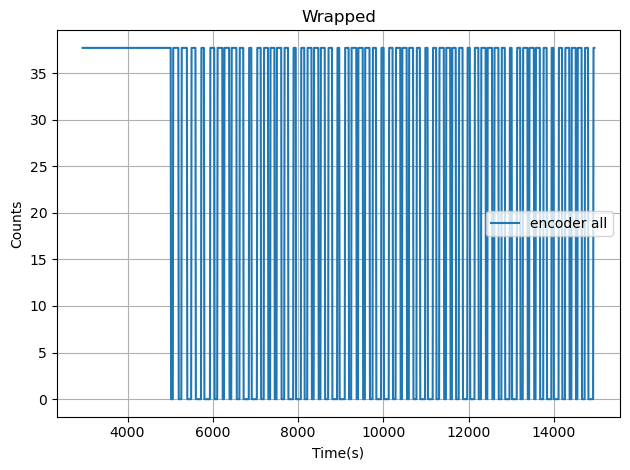

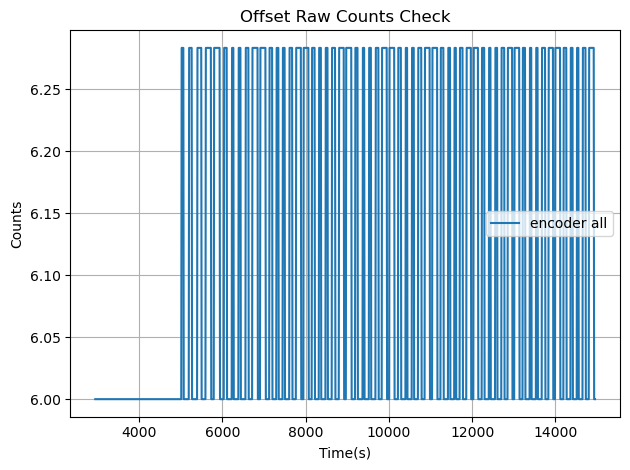

In [22]:
wrapped_offset=np.mod(offset, TPR) #find what fraction of a rotation it's at 
#wrapped_offset[wrapped_offset ==0] = TPR
angle=2*np.pi

# wrap the ticks within 12 per rev
encoder_all = angle*wrapped_offset #for the solver in radians
encoder_all_unwrapped = np.unwrap(wrapped_offset)

#should be offset shift then wrapped sawtooth
plt.figure()
plt.plot(time, encoder_all, label='encoder all')
plt.xlabel('Time(s)')
plt.ylabel('Counts')
plt.title('Wrapped')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#should be offset shift then increase to infinity
plt.figure()
plt.plot(time, encoder_all_unwrapped, label='encoder all')
plt.xlabel('Time(s)')
plt.ylabel('Counts')
plt.title('Offset Raw Counts Check')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

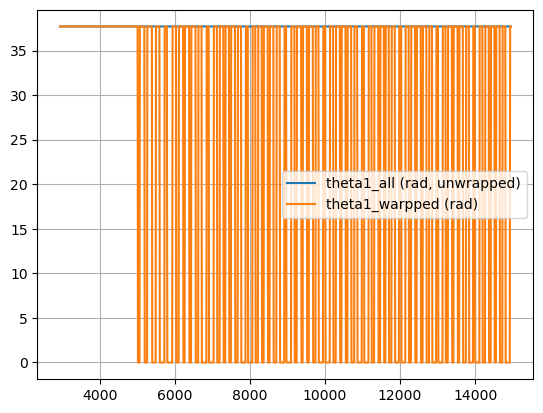

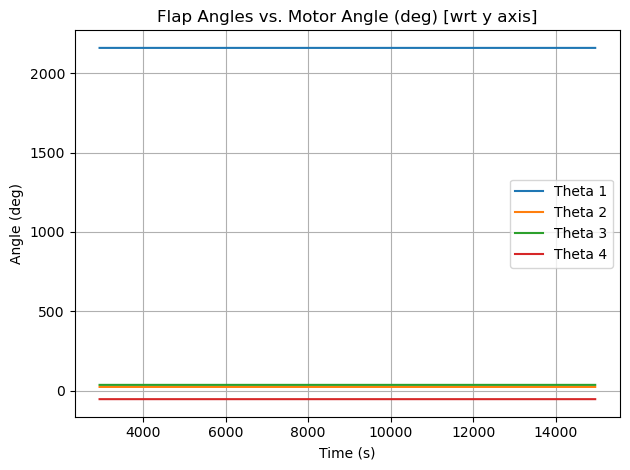

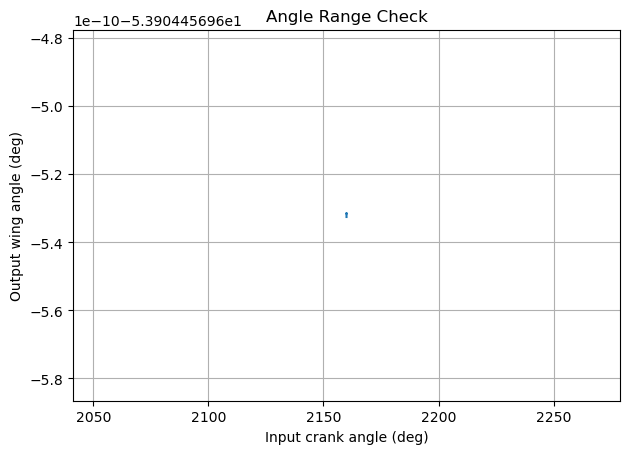

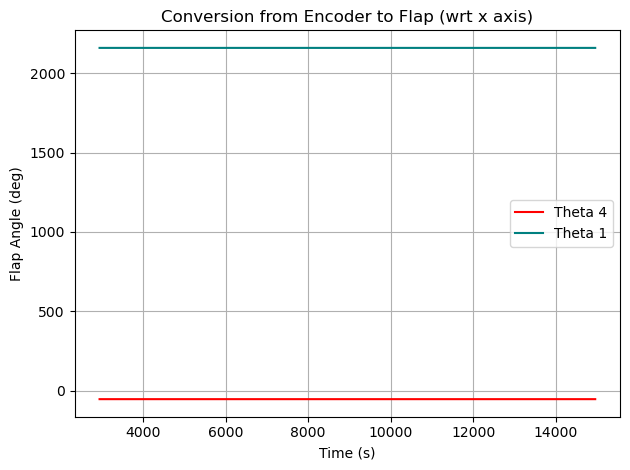

[-53.90445697 -53.90445697 -53.90445697 ... -53.90445697 -53.90445697
 -53.90445697]
[53.90445697 53.90445697 53.90445697 ... 53.90445697 53.90445697
 53.90445697]


In [24]:
#solver
# link lengths (mm)
L1 = 5.5  # input
L2 = 11.55  # coupler
L3 = 7.70  # output
L4 = 9.90  # fixed base

theta1_wrapped = encoder_all
theta1_deg_wrap=np.rad2deg(theta1_wrapped)

#unwrapped continuous for plotting
theta1_all = np.unwrap(theta1_wrapped)
theta1_deg_all =np.rad2deg(theta1_all)

# storage for outputs
theta2_output = []
theta3_output = []
theta4_output= []
theta4_y = []

#guessing a starting value for values of theta 2 and 3 
initial_guess=[np.radians(60), np.radians(30)]

#write key functions from calculations
def sys_equations(unknowns, theta1_wrapped,L1,L2,L3,L4):
    theta2, theta3= unknowns
    equation1=L1*np.cos(theta1_wrapped)+L2*np.cos(theta2)-L3*np.cos(theta3)-L4
    equation2=L1*np.sin(theta1_wrapped)+L2*np.sin(theta2)-L3*np.sin(theta3)
    return[equation1,equation2]

# loop through each input angle and find the unknowns
for t1 in theta1_wrapped:
        #fsolve is (func, x0, args) 
        solution=fsolve(sys_equations, initial_guess, args=(t1,L1,L2,L3,L4))
        theta2, theta3=solution
        #final output flap angle wrt x and y axis
        theta4=np.radians(90)-theta3 
        theta4_yaxis=np.radians(180)-theta3
        theta2_output.append(theta2)
        theta3_output.append(theta3)
        theta4_output.append(theta4)
        theta4_y.append(theta4_yaxis)
        
        #continuously update to test other values
        initial_guess=solution
        
#test value to make sure loading from file
#print("Theta2 (first 5):", theta2_output[:5])

#plot in radians

#plt.figure(1)
#plt.plot(time, theta1_wrapped, label='Theta 1')
#plt.plot(time, theta2_output, label='Theta 2')
#plt.plot(time, theta3_output, label='Theta 3')
#plt.plot(time, theta4_output, label='Theta 4')
#plt.xlabel('Time (s)')
#plt.ylabel('Angle (rad)')
#plt.title('Four-Bar Linkage Output Angles vs. Input Angle(rad)')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


#conversion back to original degrees to check graph (has to be after trig)
deg_theta1= theta1_deg_all
deg_theta2=np.rad2deg(theta2_output)
deg_theta3=np.rad2deg(theta3_output)
deg_theta4=np.rad2deg(theta4_output)
deg_theta4_y=np.rad2deg(theta4_y)
theta4_adjusted=deg_theta4

plt.figure()
#plt.plot(time, encoder_all, label="encoder_all (rad, wrapped 0–2π)")
plt.plot(time, theta1_all, label="theta1_all (rad, unwrapped)")
plt.plot(time, theta1_wrapped, label="theta1_warpped (rad)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(2)
plt.plot(time, deg_theta1, label='Theta 1')
plt.plot(time, deg_theta2, label='Theta 2')
plt.plot(time, deg_theta3, label='Theta 3')
plt.plot(time, -deg_theta4, label='Theta 4')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Flap Angles vs. Motor Angle (deg) [wrt y axis]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# angle range check plot
plt.plot(deg_theta1, -theta4_adjusted)
plt.xlabel('Input crank angle (deg)')
plt.ylabel('Output wing angle (deg)')
plt.title('Angle Range Check')
plt.grid(True)
plt.tight_layout()
plt.show()

#output plot
plt.figure(3)
plt.plot(time, -theta4_adjusted, label='Theta 4', color= 'red')
plt.plot(time, deg_theta1, label='Theta 1', color= 'teal')
plt.xlabel('Time (s)')
plt.ylabel('Flap Angle (deg)')
plt.title('Conversion from Encoder to Flap (wrt x axis)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(-deg_theta4)
print(theta4_adjusted)


#export raw and calculated to csv file (KEY: time in ms, output angle in deg)
df_raw=pd.DataFrame({
    0:time,
    1:right_count,
    2:left_count,
    3:right_theta_deg,
    4:left_theta_deg
})

df = pd.DataFrame({
    0: time,
    1: deg_theta4,
})

df_offset = pd.DataFrame({
    0:time,
    1:right_count,
    2:deg_theta1,
    3:deg_theta4,
})

title1=f"{date}both_raw_encoders.csv"
title2=f"{date}flap_output_left.txt"
title3=f"{date}offset.txt"

# save to CSV without index and header (matlab-fix)
df_raw.to_csv(title1, index=False, header=False)
df.to_csv(title2, index=False, header=False)
df_offset.to_csv(title3, index=False, header=False)
